## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from PIL import Image
import napari
import tifffile
from matplotlib import pyplot as plt
from skvideo import io as skvideo_io

from seghub.segbox import SegBox
from seghub.vgg16_utils import get_vgg16_feature_space
from seghub.dino_utils import get_dinov2_feature_space
from seghub.classif_utils import get_pca_features, get_kmeans_clusters

c:\Users\roman\anaconda3\envs\seghub_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## General handling of feature extractors

Create an instance of segbox called my_sb. Add a first feature extractor and print informations about my_sb.

In [7]:
my_sb = SegBox()
my_sb.add_extractor("VGG16-small", get_vgg16_feature_space, {"layer_list":[0], "scalings":[1,2], "rgb_if_possible":False})

In [8]:
print(my_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-small:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0], 'scalings': [1, 2], 'rgb_if_possible': False}
  Num PCs:     False
  Smoothening: False



Remove the feature extractor and print my_sb again to verify.

In [9]:
my_sb.remove_extractor("VGG16-small")
print(my_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
  No extractors


Add a new feature extractor and print to verify. When adding another feature extractor with the same name, we get an error message.

In [10]:
my_sb.add_extractor("VGG16-large", get_vgg16_feature_space, {"layer_list":[0,2], "scalings":[1,2,4,8]})
print(my_sb)
# my_sb.add_extractor("VGG16-large", get_vgg16_feature_space, {"layer_list":[0,2,5], "scalings":[1,2,4,8]})

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-large:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0, 2], 'scalings': [1, 2, 4, 8]}
  Num PCs:     False
  Smoothening: False



We can use `overwrite=True` to overwrite a feature extractor with the same name.

In [11]:
my_sb.add_extractor("VGG16-large", get_vgg16_feature_space, {"layer_list":[0,2,5], "scalings":[1,2,4,8]}, overwrite=True)
print(my_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-large:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0, 2, 5], 'scalings': [1, 2, 4, 8]}
  Num PCs:     False
  Smoothening: False



Let's add a second feature extractor.

In [12]:
my_sb.add_extractor("DINOv2-s_r", get_dinov2_feature_space, {"dinov2_model":"s_r"})
print(my_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-large:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0, 2, 5], 'scalings': [1, 2, 4, 8]}
  Num PCs:     False
  Smoothening: False
DINOv2-s_r:
  Function:    get_dinov2_feature_space
  Config:      {'dinov2_model': 's_r'}
  Num PCs:     False
  Smoothening: False



## Extractor configs and general options

We can change the parameters for a feature extractor function by changing its config. Let's change the VGG16 layers back to [0, 2].

In [13]:
my_sb.set_extractor_cfg("VGG16-large", {"layer_list":[0,2], "scalings":[1,2,4,8]})

We can also change options such as principal components used or smoothening applied for each feature extractor individually.

In [14]:
my_sb.set_extractor_options("VGG16-large", num_pcs=3, smoothening=4)
print(my_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-large:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0, 2], 'scalings': [1, 2, 4, 8]}
  Num PCs:     3
  Smoothening: 4
DINOv2-s_r:
  Function:    get_dinov2_feature_space
  Config:      {'dinov2_model': 's_r'}
  Num PCs:     False
  Smoothening: False



## Test feature extraction

Let's load an image and according labels to test feature extraction and segmentation methods.

In [2]:
img = np.array(Image.open("../data/shark_test_vid_frame0.png")) / 255
labels = tifffile.imread("../data/shark_vid_labels_frame0.tif")

With the options chosen for a specific feature extractor, we can perform the feature extraction of that extractor alone.

In [16]:
features = my_sb.extract_features_single_extractor(img, "VGG16-large")
features.shape

(480, 640, 3)

Since we chose for the VGG16-large model to use 3 principal components only, we can display it as an RGB image.

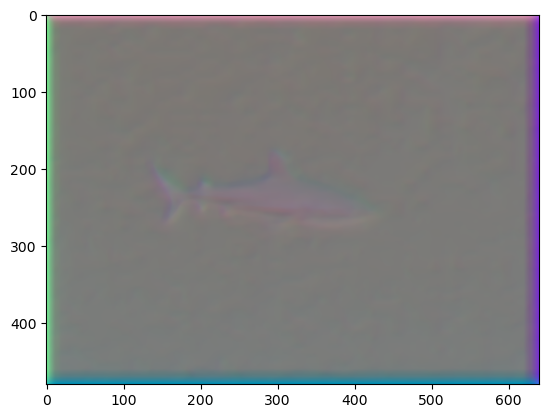

In [17]:
plt.imshow(features)
plt.show()

Most importantly, we can extract all combined features.

In [18]:
all_features = my_sb.extract_features(img)
all_features.shape

C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


(480, 640, 387)

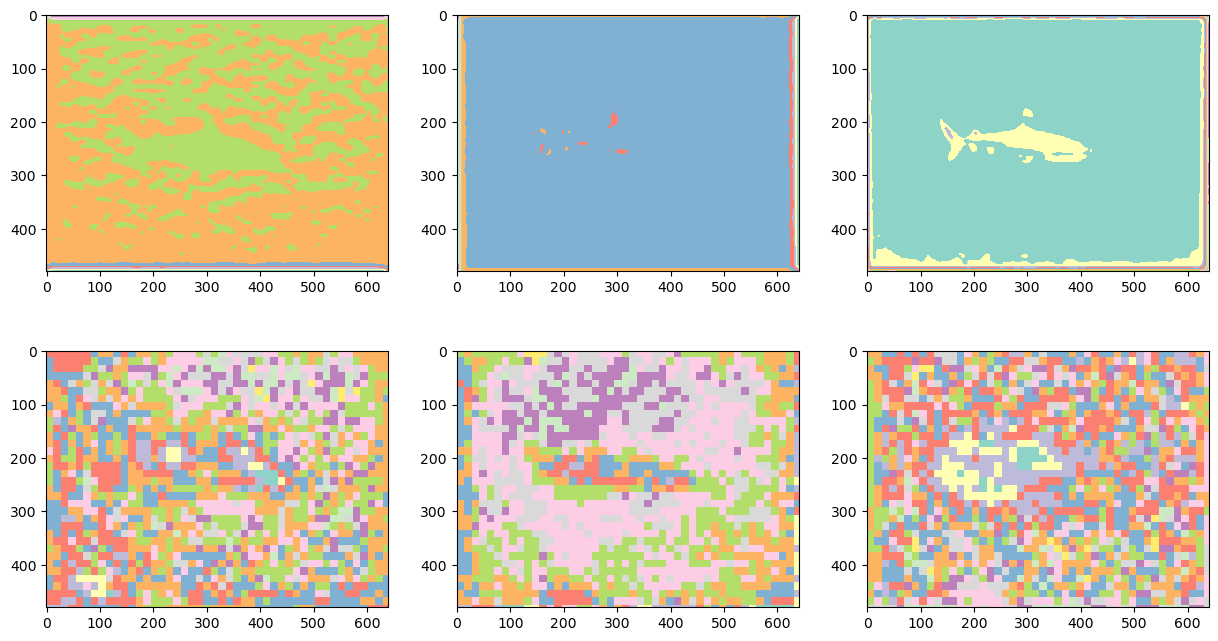

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

for i in range(6):
    ax.flatten()[i].imshow(all_features[:,:,i], cmap="Set3", interpolation="none")

## Segmentation with random forest and kmeans

Based on this feature extraction functionality, we can train a random forest classifier for an image and according annotations.

Let's first set the random state for the random forest for reproducibility, and then train the model.

In [20]:
my_sb.set_rf_settings(n_estimators=100, random_state=0)
print(my_sb.get_rf_settings())
my_sb.rf_train(img, labels)

  Nr. estimators: 100
  Random state:   0



With the trained random forest in my_sb, we can predict the segmentation of an image using the same feature extraction protocol.

In [21]:
pred = my_sb.rf_predict(img)

There is also a method to perform training and prediction on the same image, extracting the features only once.

In [22]:
selfpred = my_sb.rf_selfpredict(img, labels)

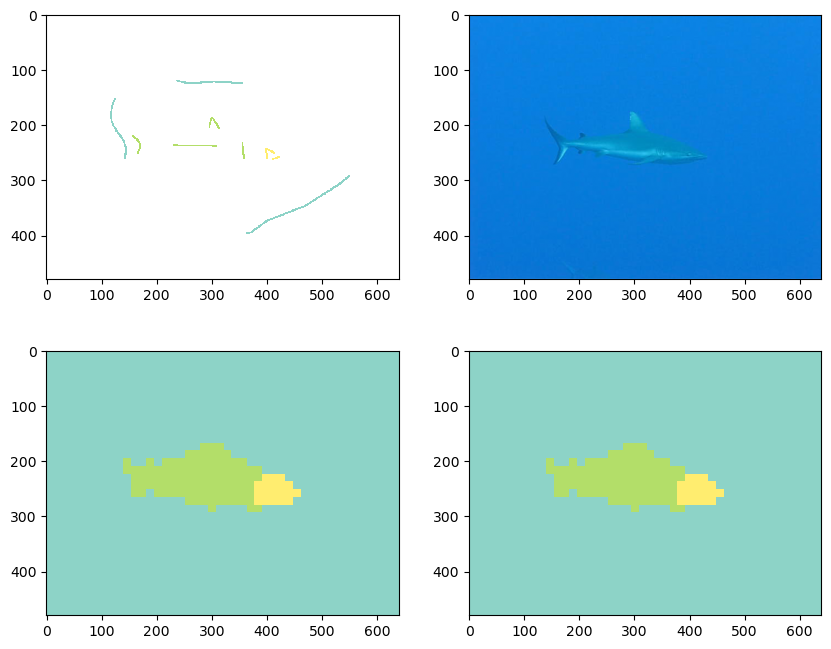

In [23]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
labels_mask = labels>0
labels_masked = np.ma.masked_where(labels_mask==0, labels)
ax[0,0].imshow(labels_masked, cmap="Set3", interpolation="none")
ax[0,1].imshow(img)
ax[1,0].imshow(pred, cmap="Set3", interpolation="none")
ax[1,1].imshow(selfpred, cmap="Set3", interpolation="none")

Based on the combined features we can also perform an unsupervised clustering using the k-means algorithm.

In [24]:
clusters = my_sb.get_kmeans(img, 3)

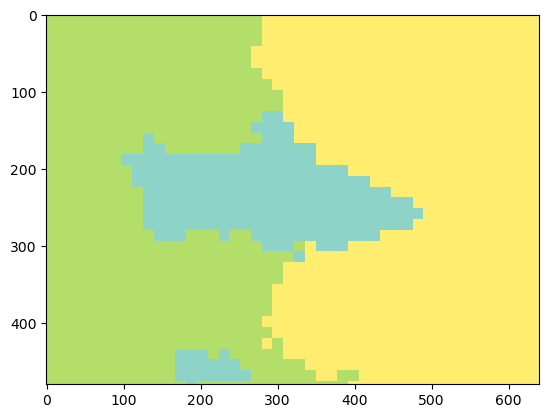

In [25]:
plt.imshow(clusters, cmap="Set3", interpolation="none")

## Show additional methods

We can also add multiple feature extractors at once, which can speed up the generation of specific SegBox instances.

In [26]:
new_sb = SegBox()
vgg16_l = {"func": get_vgg16_feature_space, "cfg": {"layer_list":[0,2], "scalings":[1,2,4,8]}}
vgg16_s = {"func": get_vgg16_feature_space, "cfg": {"layer_list":[0], "scalings":[1,2]}, "num_pcs": 3, "smoothening": 4}
dino_s_r = {"func": get_dinov2_feature_space, "cfg": {"dinov2_model":"s_r"}}
new_sb.add_extractors({"VGG16-large": vgg16_l, "VGG16-small": vgg16_s, "DINOv2-s_r": dino_s_r})
new_sb.set_rf_settings(n_estimators=100, random_state=0)
print(new_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   0
FEATURE EXTRACTORS:
VGG16-large:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0, 2], 'scalings': [1, 2, 4, 8]}
  Num PCs:     False
  Smoothening: False
VGG16-small:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0], 'scalings': [1, 2]}
  Num PCs:     3
  Smoothening: 4
DINOv2-s_r:
  Function:    get_dinov2_feature_space
  Config:      {'dinov2_model': 's_r'}
  Num PCs:     False
  Smoothening: False



In [27]:
print(new_sb.get_extractor_info("VGG16-large"))

VGG16-large:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0, 2], 'scalings': [1, 2, 4, 8]}
  Num PCs:     False
  Smoothening: False



## Test batch handling

Test the methods for batch handling.

In [28]:
another_sb = SegBox()
another_sb.add_extractor("DINOv2_s-r", get_dinov2_feature_space, {"dinov2_model":"s_r"})

In [29]:
img_batch = [img]*3
labels_batch = [np.zeros_like(labels)] + [labels] + [np.zeros_like(labels)]

Method to train on a batch of images and a batch of labels.

In [30]:
another_sb.rf_train_batch(img_batch, labels_batch, print_progress=True)

Extracting features for labels 1/1 - estimated time left: NA


Predict on a batch of images. Also show that the history of predictions is being saved.

In [31]:
another_sb.rf_predict_batch(img_batch, print_progress=True)
pred_batch = another_sb.prediction_history[-1]

Predicting image 1/3 - estimated time left: NA
Predicting image 2/3 - estimated time left: 10.8 seconds
Predicting image 3/3 - estimated time left: 5.2 seconds


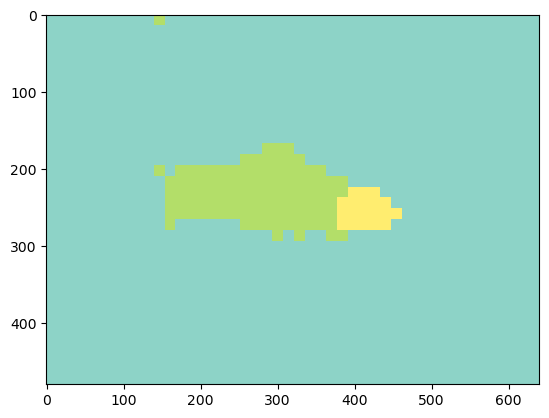

In [32]:
plt.imshow(pred_batch[0], cmap="Set3", interpolation="none")

Method for direct training on one batch of images and labels and predicting on the same or another batch of images.

In [33]:
another_sb.rf_segment([img]*3, [labels]+[np.zeros_like(labels)]*2, print_progress=True)
seg = another_sb.prediction_history[-1]

Extracting features for labels 1/1 - estimated time left: NA
Predicting image 1/3 - estimated time left: NA
Predicting image 2/3 - estimated time left: 9.3 seconds
Predicting image 3/3 - estimated time left: 4.6 seconds


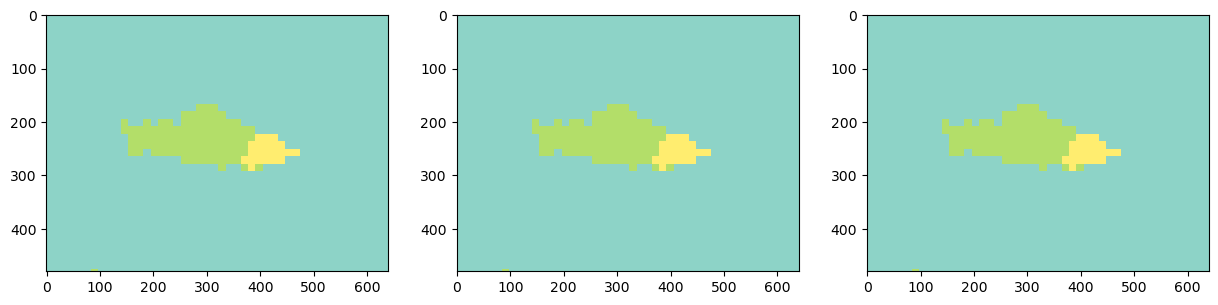

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    ax.flatten()[i].imshow(seg[i], cmap="Set3", interpolation="none")

## Saving and loading

Save a trained random forest model and information about feature extractors, options and random forest settings.

In [35]:
next_sb = SegBox()
next_sb.add_extractor("VGG16-small", get_vgg16_feature_space, {"layer_list":[0], "scalings":[1,2], "rgb_if_possible":False})
print(next_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-small:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0], 'scalings': [1, 2], 'rgb_if_possible': False}
  Num PCs:     False
  Smoothening: False



In [36]:
next_sb.rf_train(img, labels)

In [37]:
next_sb.rf_save("../data/vgg16-s-noRGB_rf")

Create a new SegBox object and load the saved random forest model into it (first assure they use the same options/settings).

In [38]:
loaded_sb = SegBox()
loaded_sb.rf_load("../data/vgg16-s-noRGB_rf")
print(loaded_sb)

Segmentation Box
OPTIONS:
  IMG as feature:  False
  PCs as features: False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-small:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0], 'rgb_if_possible': False, 'scalings': [1, 2]}
  Num PCs:     False
  Smoothening: False



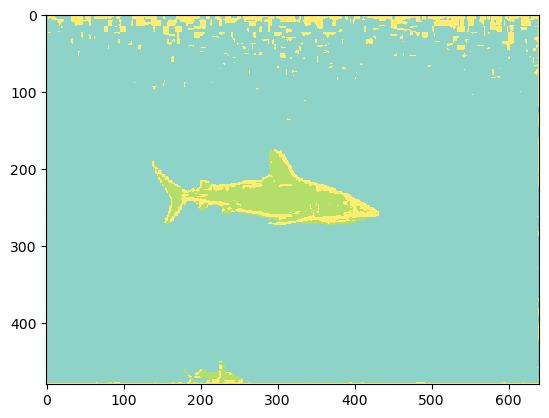

In [39]:
pred_loaded = loaded_sb.rf_predict(img)
plt.imshow(pred_loaded, cmap="Set3", interpolation="none")

Check that changing an option after loading (or training) a rf leads to a warning.

In [40]:
loaded_sb.set_options(pcs_as_features=3)

Warning, options changed. Random Forest model might not be compatible anymore.


In [41]:
print(loaded_sb)

Segmentation Box
OPTIONS:
  PCs as features: 3
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-small:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0], 'rgb_if_possible': False, 'scalings': [1, 2]}
  Num PCs:     False
  Smoothening: False



Show that using different numbers of features leads to an error:

In [42]:
# loaded_sb.rf_predict(img)

## Using pca and image channels as features

Show pca and channels as features

In [43]:
final_sb = SegBox()
final_sb.set_options(img_as_feature=True)

In [44]:
# Confirm that image is added independently of feature extraction
img_feature = final_sb.extract_features(img)
print(img_feature.shape)

(480, 640, 3)


In [45]:
# Show that image is added to the feature space as last dimensions
final_sb.add_extractor("VGG16-small", get_vgg16_feature_space, {"layer_list":[0], "scalings":[1,2]})
features_with_img = final_sb.extract_features(img)
print(features_with_img.shape)

(480, 640, 131)


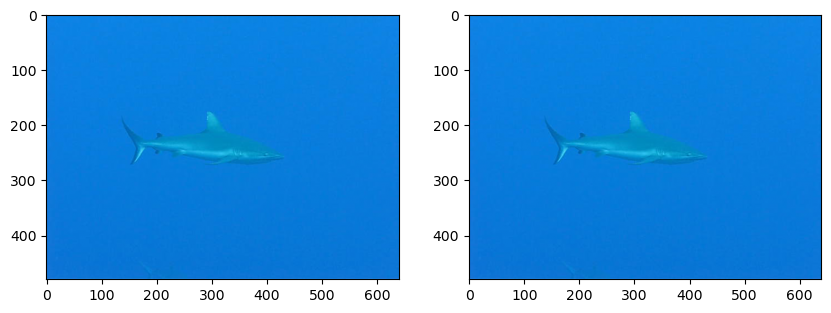

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(img_feature)
ax[1].imshow(features_with_img[:,:,-3:])

In [47]:
final_sb.set_options(img_as_feature=False)
only_extracted = final_sb.extract_features(img)
print(only_extracted.shape)
pc_on_extracted = get_pca_features(only_extracted, 3)

(480, 640, 128)


In [48]:
final_sb.set_options(pcs_as_features=3)
extracted_with_pc = final_sb.extract_features(img)
print(extracted_with_pc.shape)

(480, 640, 131)


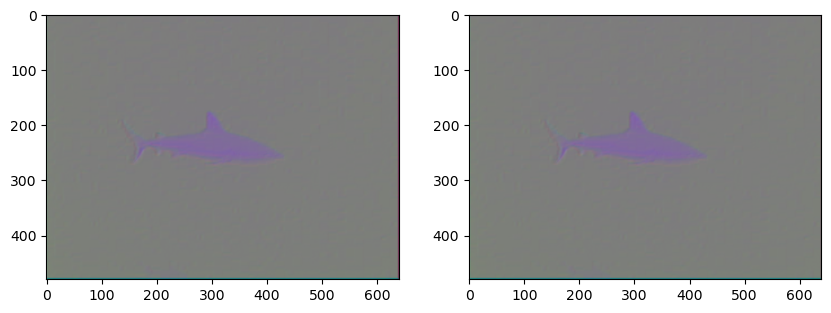

In [49]:
# Show that pca features are added to the feature space as first dimensions
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(pc_on_extracted)
ax[1].imshow(extracted_with_pc[:,:,:3])

## Test custom dinov2

In [2]:
from seghub.custom_dinov2 import get_custom_dinov2_feature_space

c:\Users\roman\anaconda3\envs\seghub_env\lib\site-packages\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
c:\Users\roman\anaconda3\envs\seghub_env\lib\site-packages\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
c:\Users\roman\anaconda3\envs\seghub_env\lib\site-packages\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [44]:
# img = np.array(Image.open("../data/shark_test_vid_frame0.png"))[120:320,110:470]
# img = np.array(Image.open("../data/cellpose_test_image_011_img.png"))
img = np.array(Image.open("../data/cellpose_train_200_img.png"))[20:220,100:400]
# labels = tifffile.imread("../data/shark_vid_labels_frame0.tif")[120:320,110:470]
labels = np.array(Image.open("../data/cellpose_train_200_scribbles_all_00500_w1_run05.png"))[20:220,100:400]
gt = np.array(Image.open("../data/cellpose_train_200_ground_truth.png"))[20:220,100:400]
print(img.shape)

(200, 300, 3)


In [45]:
# np.sum(labels==2)

In [51]:
pth_path_run005 = "D:/Documents/Beruf & Ausbildung/Ausbildung/22-08 MSC Bioinf/24FS_Master Thesis/03_train_DINOv2/pth/cellpose1-2_run005_teacher_checkpoint.pth"
pth_path_run003 = "D:/Documents/Beruf & Ausbildung/Ausbildung/22-08 MSC Bioinf/24FS_Master Thesis/03_train_DINOv2/pth/cellpose1-2_run003_teacher_checkpoint.pth"

In [ ]:
feat = get_custom_dinov2_feature_space(img/255, pth_path_run005, device="cpu", load_weights=True)

In [48]:
pcs = get_pca_features(feat, 3)
km = get_kmeans_clusters(feat, 2)
pcs_img = get_pca_features(img, 3)
km_img = get_kmeans_clusters(img, 2)

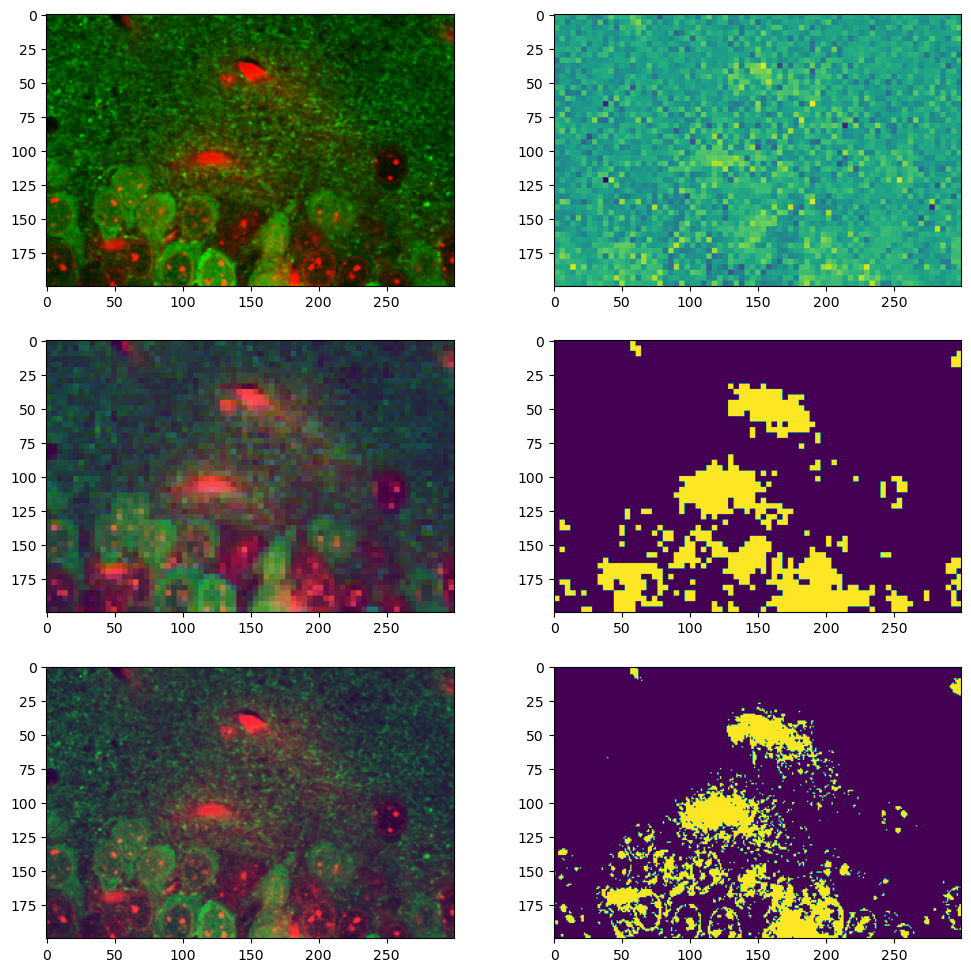

In [49]:
fig, ax = plt.subplots(3, 2, figsize=(img.shape[1]/50*2, img.shape[0]/50*3))
ax[0,0].imshow(img)
ax[0,1].imshow((feat[:,:,0]-feat[:,:,0].min())/(feat[:,:,0].max()-feat[:,:,0].min()))
ax[1,0].imshow(pcs)
ax[1,1].imshow(km)
ax[2,0].imshow(pcs_img)
ax[2,1].imshow(km_img)
plt.show()

In [60]:
sb_custom_dv2_patch4 = SegBox()
sb_custom_dv2_patch4.add_extractor("custom_dinov2", get_custom_dinov2_feature_space, {"teacher_pth_path":pth_path_run005, "device":"cpu", "load_weights":True})
# sb_custom_dv2_patch4.set_options(pred_smoothening=8)
pred_custom_dv2_patch4 = sb_custom_dv2_patch4.rf_selfpredict(img/255, labels)

In [64]:
sb_custom_dv2_empty_patch4 = SegBox()
sb_custom_dv2_empty_patch4.add_extractor("custom_dinov2_empty", get_custom_dinov2_feature_space, {"teacher_pth_path":pth_path_run005, "device":"cpu", "load_weights":False})
# sb_custom_dv2_empty_patch4.set_options(pred_smoothening=8)
pred_custom_dv2_empty_patch4 = sb_custom_dv2_empty_patch4.rf_selfpredict(img/255, labels)

In [55]:
sb_custom_dv2_patch14 = SegBox()
sb_custom_dv2_patch14.add_extractor("custom_dinov2", get_custom_dinov2_feature_space, {"teacher_pth_path":pth_path_run003, "device":"cpu", "load_weights":True})
# sb_custom_dv2_patch14.set_options(pred_smoothening=8)
pred_custom_dv2_patch14 = sb_custom_dv2_patch14.rf_selfpredict(img/255, labels)

In [56]:
sb_channels = SegBox()
sb_channels.set_options(img_as_feature=True)
# sb_channels.set_options(pred_smoothening=8)
pred_channels = sb_channels.rf_selfpredict(img/255, labels)

In [57]:
sb_dv2 = SegBox()
sb_dv2.add_extractor("dinov2", get_dinov2_feature_space, {"dinov2_model":"s_r"})
pred_dv2 = sb_dv2.rf_selfpredict(img/255, labels)

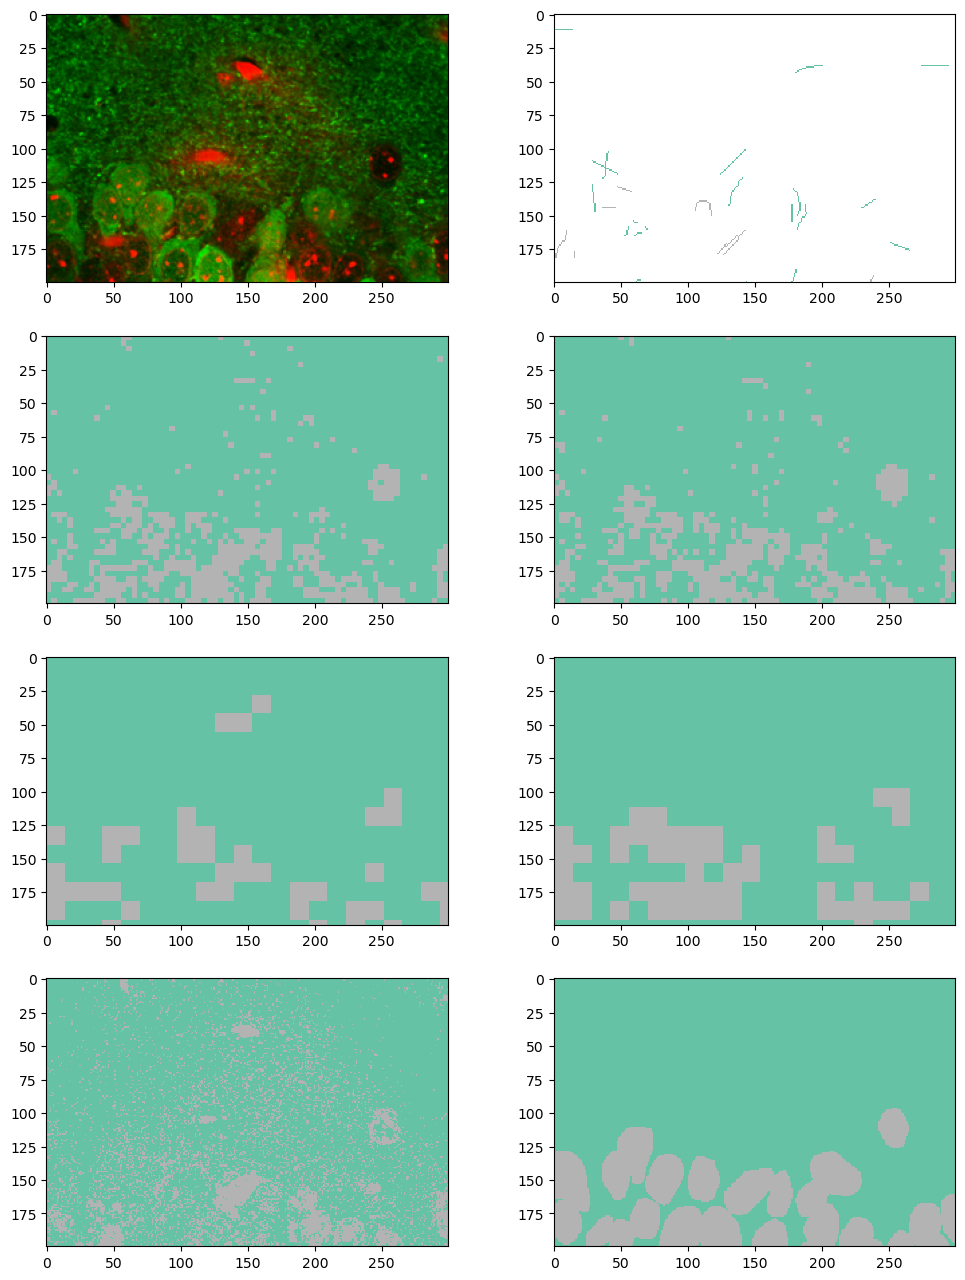

In [63]:
fig, ax = plt.subplots(4, 2, figsize=(img.shape[1]/50*2, img.shape[0]/50*4))
ax[0,0].imshow(img)
labels_mask = labels>0
labels_masked = np.ma.masked_where(labels_mask==0, labels)
ax[0,1].imshow(labels_masked, cmap="Set2", interpolation="none")
ax[1,0].imshow(pred_custom_dv2_patch4, cmap="Set2", interpolation="none")
ax[1,1].imshow(pred_custom_dv2_empty_patch4, cmap="Set2", interpolation="none")
ax[2,0].imshow(pred_custom_dv2_patch14, cmap="Set2", interpolation="none")
ax[2,1].imshow(pred_dv2, cmap="Set2", interpolation="none")
ax[3,0].imshow(pred_channels, cmap="Set2", interpolation="none")
ax[3,1].imshow(gt, cmap="Set2", interpolation="none")
plt.show()